In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
deep_data= pd.read_csv("train_data_processed.csv", parse_dates=['Date'])

C:\Users\pooji\AppData\Local\Temp\ipykernel_15828\3615870667.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  deep_data= pd.read_csv("train_data_processed.csv", parse_dates=['Date'])


In [3]:
deep_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,weekday,...,DayOfMonth,Month,Year,Quarter,DayOfYear,WeekOfYear,IsWeekday,IsWeekend,Sales_to_Customers_Ratio,Sales_to_Stores_Open_Ratio
0,1,5,2015-07-31,5263,555,1,1,0,1,1,...,31,7,2015,3,212,31,0,1,9.482883,5263.0
1,2,5,2015-07-31,6064,625,1,1,0,1,1,...,31,7,2015,3,212,31,0,1,9.702400,6064.0
2,3,5,2015-07-31,8314,821,1,1,0,1,1,...,31,7,2015,3,212,31,0,1,10.126675,8314.0
3,4,5,2015-07-31,13995,1498,1,1,0,1,1,...,31,7,2015,3,212,31,0,1,9.342457,13995.0
4,5,5,2015-07-31,4822,559,1,1,0,1,1,...,31,7,2015,3,212,31,0,1,8.626118,4822.0


In [4]:
deep_data.sort_values(by='Date', inplace=True)

In [5]:
sales_data=deep_data[['Date','Sales']]

In [6]:
sales_data

,Date,Sales
1017208,2013-01-01,0
1016473,2013-01-01,0
1016472,2013-01-01,0
1016471,2013-01-01,0
1016470,2013-01-01,0
...,...,...
745,2015-07-31,9082
746,2015-07-31,10708
747,2015-07-31,7481
741,2015-07-31,10460


In [7]:
deep_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 1017208 to 0
Data columns (total 25 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   Store                       1017209 non-null  int64         
 1   DayOfWeek                   1017209 non-null  int64         
 2   Date                        1017209 non-null  datetime64[ns]
 3   Sales                       1017209 non-null  int64         
 4   Customers                   1017209 non-null  int64         
 5   Open                        1017209 non-null  int64         
 6   Promo                       1017209 non-null  int64         
 7   StateHoliday                1017209 non-null  object        
 8   SchoolHoliday               1017209 non-null  int64         
 9   weekday                     1017209 non-null  int64         
 10  weekend                     1017209 non-null  int64         
 11  is_holiday              

In [8]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [9]:
deep_data.set_index('Date', inplace=True)

In [10]:
ts_data = deep_data['Sales'].resample('D').sum()

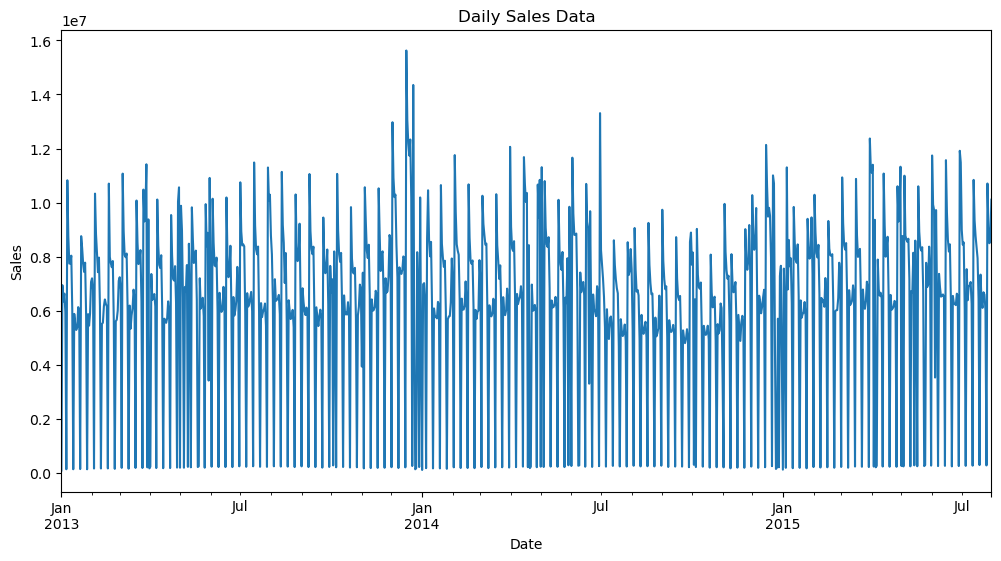

In [11]:
ts_data.plot(figsize=(12, 6))
plt.title('Daily Sales Data')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [12]:
from statsmodels.tsa.stattools import adfuller 
result = adfuller(ts_data)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}:{value}')

ADF Statistic: -4.7616145245956165
p-value: 6.436731330559263e-05
Critical Values:
   1%:-3.437470108019385
   5%:-2.8646832620852853
   10%:-2.5684436698650503


In [13]:
if result[1] > 0.05:
    ts_data_diff = ts_data.diff().dropna()
else:
    ts_data_diff=ts_data

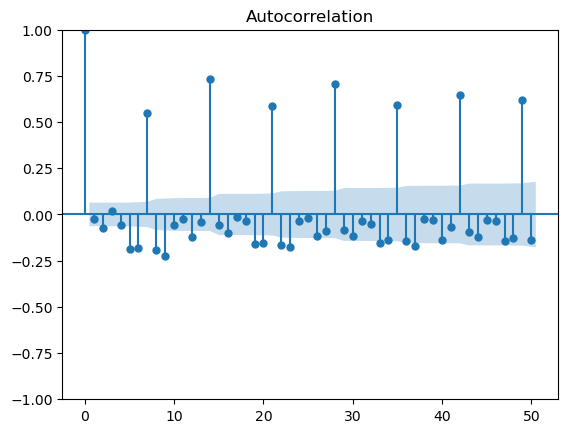

In [14]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(ts_data_diff, lags=50)
plt.title('Autocorrelation')
plt.show()

c:\Users\pooji\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


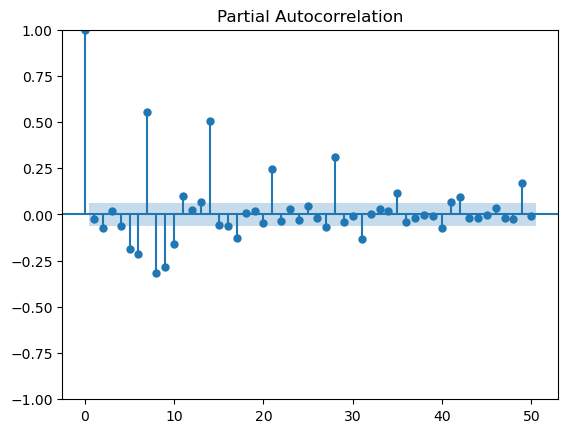

In [15]:
plot_pacf(ts_data_diff, lags=50)
plt.title('Partial Autocorrelation')
plt.show()

In [16]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    df = pd.DataFrame(data)
    cols = []
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    agg = pd.concat(cols, axis=1)
    if dropnan:
        agg.dropna(inplace=True)
    return agg

n_lag = 7
supervised_data = series_to_supervised(ts_data_diff, n_lag, 1)
print(supervised_data.head())

                Sales      Sales       Sales       Sales       Sales  \
Date                                                                   
2013-01-08    97235.0  6949829.0   6347820.0   6638954.0   5951593.0   
2013-01-09  6949829.0  6347820.0   6638954.0   5951593.0    143904.0   
2013-01-10  6347820.0  6638954.0   5951593.0    143904.0  10826848.0   
2013-01-11  6638954.0  5951593.0    143904.0  10826848.0   8749437.0   
2013-01-12  5951593.0   143904.0  10826848.0   8749437.0   7746603.0   

                 Sales       Sales    Sales  
Date                                         
2013-01-08    143904.0  10826848.0  8749437  
2013-01-09  10826848.0   8749437.0  7746603  
2013-01-10   8749437.0   7746603.0  7751485  
2013-01-11   7746603.0   7751485.0  8039306  
2013-01-12   7751485.0   8039306.0  6017491  


In [17]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(supervised_data)

In [18]:
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]
train_X, train_y = train_data[:, :-1], train_data[:, -1]
test_X, test_y = test_data[:, :-1], test_data[:,-1]

In [19]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [20]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [21]:
history = model.fit(train_X, train_y, epochs=50, batch_size=64, validation_data=(test_X, test_y), verbose=2,shuffle=False)

Epoch 1/50

12/12 - 8s - loss: 0.1921 - val_loss: 0.1775 - 8s/epoch - 651ms/step
Epoch 2/50
12/12 - 0s - loss: 0.1669 - val_loss: 0.1671 - 138ms/epoch - 12ms/step
Epoch 3/50
12/12 - 0s - loss: 0.1512 - val_loss: 0.1602 - 133ms/epoch - 11ms/step
Epoch 4/50
12/12 - 0s - loss: 0.1407 - val_loss: 0.1532 - 140ms/epoch - 12ms/step
Epoch 5/50
12/12 - 0s - loss: 0.1319 - val_loss: 0.1449 - 148ms/epoch - 12ms/step
Epoch 6/50
12/12 - 0s - loss: 0.1235 - val_loss: 0.1365 - 130ms/epoch - 11ms/step
Epoch 7/50
12/12 - 0s - loss: 0.1159 - val_loss: 0.1289 - 130ms/epoch - 11ms/step
Epoch 8/50
12/12 - 0s - loss: 0.1093 - val_loss: 0.1226 - 133ms/epoch - 11ms/step
Epoch 9/50
12/12 - 0s - loss: 0.1039 - val_loss: 0.1178 - 130ms/epoch - 11ms/step
Epoch 10/50
12/12 - 0s - loss: 0.0998 - val_loss: 0.1141 - 130ms/epoch - 11ms/step
Epoch 11/50
12/12 - 0s - loss: 0.0968 - val_loss: 0.1114 - 140ms/epoch - 12ms/step
Epoch 12/50
12/12 - 0s - loss: 0.0948 - val_loss: 0.1095 - 173ms/epoch - 14ms/step
Epoch 13/50
12

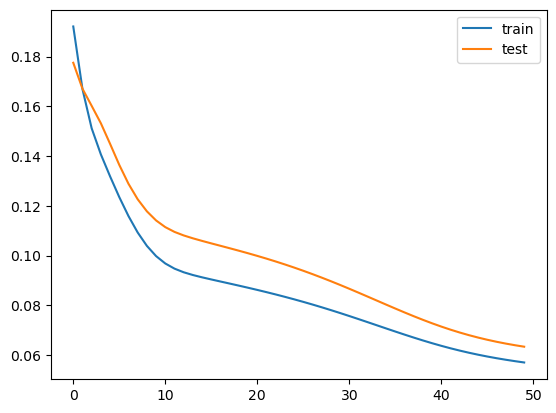

In [22]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [23]:
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

6/6 [==============================] - 0s 5ms/step


In [24]:
model=Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(11,activation='relu',input_dim=11))#hidden layer 1
model.add(Dense(11,activation='relu'))
model.add(Dense(1,activation='sigmoid'))#output layer

In [25]:
model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [26]:
history = model.fit(train_X, train_y, epochs=5, batch_size=64, validation_data=(test_X, test_y), verbose=2,shuffle=False)

Epoch 1/5



12/12 - 8s - loss: 0.6383 - accuracy: 0.0000e+00 - val_loss: 0.6019 - val_accuracy: 0.0000e+00 - 8s/epoch - 655ms/step
Epoch 2/5
12/12 - 0s - loss: 0.5292 - accuracy: 0.0000e+00 - val_loss: 0.5035 - val_accuracy: 0.0000e+00 - 135ms/epoch - 11ms/step
Epoch 3/5
12/12 - 0s - loss: 0.3963 - accuracy: 0.0000e+00 - val_loss: 0.3848 - val_accuracy: 0.0000e+00 - 135ms/epoch - 11ms/step
Epoch 4/5
12/12 - 0s - loss: 0.2307 - accuracy: 0.0000e+00 - val_loss: 0.2383 - val_accuracy: 0.0000e+00 - 126ms/epoch - 10ms/step
Epoch 5/5
12/12 - 0s - loss: 0.0241 - accuracy: 0.0000e+00 - val_loss: 0.0618 - val_accuracy: 0.0000e+00 - 129ms/epoch - 11ms/step


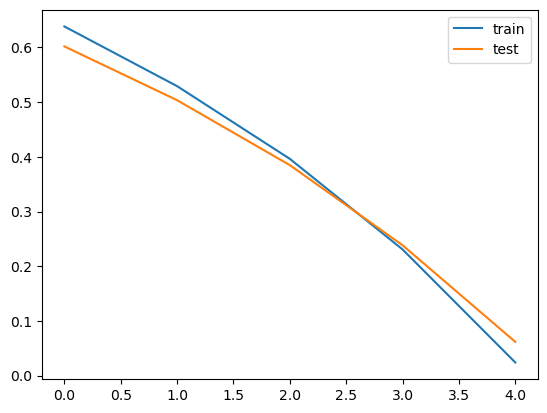

In [27]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [28]:
train_y_reshaped = train_y.reshape(-1, 1)
test_y_reshaped = test_y.reshape(-1, 1)

# Fit the scaler only on the target variable data (train_y)
scaler.fit(train_y_reshaped)

# Invert predictions
train_predict = scaler.inverse_transform(train_predict)
train_y_inv = scaler.inverse_transform(train_y_reshaped)
test_predict = scaler.inverse_transform(test_predict)
test_y_inv = scaler.inverse_transform(test_y_reshaped)

In [29]:
from sklearn.metrics import mean_squared_error

train_rmse = np.sqrt(mean_squared_error(train_y_inv, train_predict))
test_rmse = np.sqrt(mean_squared_error(test_y_inv, test_predict))
print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)

Train RMSE: 0.23779146015019298
Test RMSE: 0.2517533005410116


In [30]:
from keras.models import load_model

# Save the model using Keras
model.save("sales_predictions.h5")

# Load the model from Keras
loaded_model = load_model("sales_predictions.h5")

# Make predictions on the test data
test_predictions = loaded_model.predict(test_X)

# Display test predictions
print("Test Predictions:", test_predictions)

c:\Users\pooji\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 1s 5ms/step
Test Predictions: [[0.15219738]
 [0.16108368]
 [0.19996554]
 [0.19762199]
 [0.25332654]
 [0.22152181]
 [0.24834052]
 [0.28320265]
 [0.27625725]
 [0.29752564]
 [0.27994794]
 [0.3332004 ]
 [0.24342303]
 [0.24632847]
 [0.2865572 ]
 [0.23413408]
 [0.22487502]
 [0.19758478]
 [0.21190707]
 [0.15699303]
 [0.15568954]
 [0.17586586]
 [0.18641919]
 [0.22002077]
 [0.21361941]
 [0.27660722]
 [0.22192025]
 [0.22576158]
 [0.2598394 ]
 [0.21590683]
 [0.21236001]
 [0.18449478]
 [0.19615312]
 [0.15341252]
 [0.1582143 ]
 [0.17874554]
 [0.20319661]
 [0.25378397]
 [0.25072217]
 [0.32702732]
 [0.25662306]
 [0.2610562 ]
 [0.30464348]
 [0.24636294]
 [0.23368338]
 [0.20104255]
 [0.2148734 ]
 [0.15618978]
 [0.15528543]
 [0.17708318]
 [0.19405541]
 [0.23876953]
 [0.22794919]
 [0.29386532]
 [0.23526871]
 [0.24873109]
 [0.29093936]
 [0.231599  ]
 [0.2238083 ]
 [0.19497818]
 [0.20876212]
 [0.15470769]
 [0.15669112]
 [0.17911513]
 [0.20643696]
 [0.27500278]
 [0.290

In [40]:
import mlflow
import mlflow.keras

# Specify the desired path
desired_path = "C:/Users/pooji/AppData/Local/Packages/PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0/LocalCache/local-packages/Python39/site-packages/sales_prediction"

# Save the model using MLflow with the specified path
mlflow.keras.save_model(model, path=desired_path)

# Load the model from MLflow
loaded_model = mlflow.keras.load_model(desired_path)

# Make predictions on the test data
test_predictions = loaded_model.predict(test_X)

# Display test predictions
print("Test Predictions:", test_predictions)

2024/03/17 10:53:32 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\pooji\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sales_prediction\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\pooji\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sales_prediction\data\model\assets


c:\Users\pooji\anaconda3\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



6/6 [==============================] - 1s 3ms/step
Test Predictions: [[0.15219738]
 [0.16108368]
 [0.19996554]
 [0.19762199]
 [0.25332654]
 [0.22152181]
 [0.24834052]
 [0.28320265]
 [0.27625725]
 [0.29752564]
 [0.27994794]
 [0.3332004 ]
 [0.24342303]
 [0.24632847]
 [0.2865572 ]
 [0.23413408]
 [0.22487502]
 [0.19758478]
 [0.21190707]
 [0.15699303]
 [0.15568954]
 [0.17586586]
 [0.18641919]
 [0.22002077]
 [0.21361941]
 [0.27660722]
 [0.22192025]
 [0.22576158]
 [0.2598394 ]
 [0.21590683]
 [0.21236001]
 [0.18449478]
 [0.19615312]
 [0.15341252]
 [0.1582143 ]
 [0.17874554]
 [0.20319661]
 [0.25378397]
 [0.25072217]
 [0.32702732]
 [0.25662306]
 [0.2610562 ]
 [0.30464348]
 [0.24636294]
 [0.23368338]
 [0.20104255]
 [0.2148734 ]
 [0.15618978]
 [0.15528543]
 [0.17708318]
 [0.19405541]
 [0.23876953]
 [0.22794919]
 [0.29386532]
 [0.23526871]
 [0.24873109]
 [0.29093936]
 [0.231599  ]
 [0.2238083 ]
 [0.19497818]
 [0.20876212]
 [0.15470769]
 [0.15669112]
 [0.17911513]
 [0.20643696]
 [0.27500278]
 [0.290

In [ ]:
model.save('model.h5')

c:\Users\pooji\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.models import load_model
from joblib import dump

# Load the Keras model from the .h5 file
loaded_model = load_model('model.h5')

# Save the loaded model as a pickle file
dump(loaded_model,'model.pkl')
    

['model.pkl']